# Stellar Mass-Luminosity Bias

Suppose that stars have a mass-luminosity relationship such that $L
\propto M^3$. If we have a flux-limited survey, it will bias us
towards observing more massive stars which are not representative of
the full mass distribution. Let's see how to set this up in `popsynth`. 

## Setup the problem
First, we will assume that we have some initial mass function (IMF)
for our stars that describes how there masses are distributed. For
simplicity, we will assume that this IMF is just a log-normal distribution:

In [1]:

%matplotlib inline

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)
purple = "#B833FF"
yellow = "#F6EF5B"

import networkx as nx
import numpy as np
import warnings

warnings.simplefilter("ignore")

import popsynth

# create a sampler for mass
# we do not directly observe the mass as it is a latent quantity

initial_mass_function = popsynth.LogNormalAuxSampler(name="mass", observed = False)


We now assume the dependent variable is the luminosity, so we need a
`DerivedLumAuxSampler` that generates luminosities given a mass:

In [2]:
class MassLuminosityRelation(popsynth.DerivedLumAuxSampler):
    _auxiliary_sampler_name = "MassLuminosityRelation"
  
    def __init__(self, mu=0.0, tau=1.0, sigma=1):
        # this time set observed=True
        super(MassLuminosityRelation, self).__init__("mass_lum_relation", uses_distance=False)

    def true_sampler(self, size):
        
		# the secondary quantity is mass 
		
        mass = self._secondary_samplers["mass"].true_values
        
		# we will store the log of mass cubed
        self._true_values = 3 * np.log10(mass)

    def compute_luminosity(self):
        # compute the luminosity
		# from the relation
        return np.power(10., self._true_values)


luminosity = MassLuminosityRelation()



Now we can put everything together. First, we need to assign
`mass` as a secondary quantity to the luminosity

In [3]:
luminosity.set_secondary_sampler(initial_mass_function)

Finally, we will use a simple spherical geometry to hold our stars. We
will also put a hard flux limit on our survey to simulate a
flux-limited catalog.

In [4]:
pop_gen = popsynth.populations.SphericalPopulation(1, r_max=10)

# create the flux selection

flux_selector = popsynth.HardFluxSelection()
flux_selector.boundary = 1e-2
pop_gen.set_flux_selection(flux_selector)

# now add the luminisity sampler

pop_gen.add_observed_quantity(luminosity)


Now let's draw our survey.

In [5]:

pop = pop_gen.draw_survey(flux_sigma=0.5)


Drawing distances:   0%|          | 0/4125 [00:00<?, ?it/s]

We can now look at the distribution of the masses:


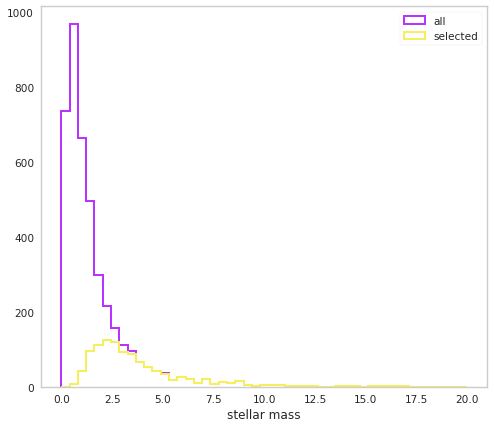

In [6]:
fig, ax = plt.subplots()

bins = np.linspace(0,20,50)

ax.hist(pop.mass,
        bins=bins,
        label='all', 
        color=purple,
        histtype="step",
        lw=2
       
       )

ax.hist(pop.mass[pop.selection],
        bins=bins,
        label='selected',
        color=yellow,
        histtype="step",
        lw=2
       )

ax.set_xlabel('stellar mass')
ax.legend()


We can see that indeed our selected masses are biased towards higher values. 

Let's look in the mass-luminostiy plane:

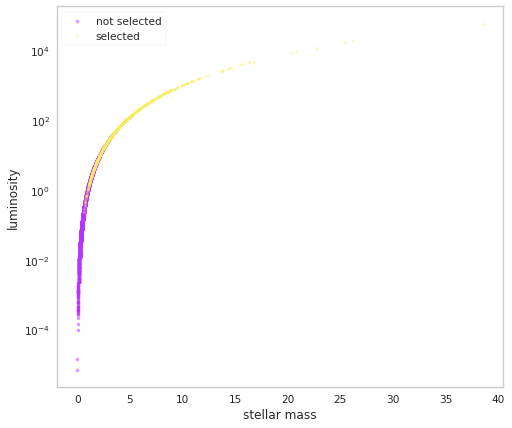

In [7]:
fig, ax = plt.subplots()

bins = np.linspace(0,20,50)

ax.scatter(pop.mass[~pop.selection],
           pop.luminosities_latent[~pop.selection],        
           label='not selected', 
           color=purple,
           alpha=0.5,
           s=10
            
            
       
       )

ax.scatter(pop.mass[pop.selection],
           pop.luminosities_latent[pop.selection],        
           label='selected', 
           color=yellow,
           alpha=0.5,
           s=5
          )



ax.set_xlabel('stellar mass')
ax.set_ylabel('luminosity')
ax.set_yscale('log')


ax.legend()

